# Младший аналитик

## Описание данных

In [1]:
import pandas as pd

In [2]:
df_spec = pd.read_csv('/content/data/executive_to_spec.csv')

In [3]:
df_spec.head(10)

,executive_id,spec
0,4444406782469255273,технолог
1,4451437494373826323,бета-тестер
2,4638737517754019940,иллюстратор
3,4769141486593889576,дизайнер
4,4782353183953487778,редактор
5,5029159030031984303,контент-менеджер
6,5114056712269157669,кодер
7,5129736847592887649,технолог
8,5142434179669108227,верстальщик
9,5184041804198118513,шрифтовик


#### executive_to_spec:
* executive_id — id специалиста; 
* spec — его специальность. 

In [4]:
df_h_projects = pd.read_csv('/content/data/hours_to_project.csv')

In [5]:
df_h_projects.head(10)

,day,project_id,executive_id,hours,dt
0,2019-01-09,3016816,6472966665163348977,4,2019-01-11 18:50:19
1,2019-01-10,3016816,6472966665163348977,4,2019-01-11 18:50:19
2,2019-01-11,3016816,6472966665163348977,4,2019-01-11 18:50:19
3,2019-01-14,3016816,6472966665163348977,4,2019-01-11 18:50:24
4,2019-01-15,3016816,6472966665163348977,4,2019-01-11 18:50:24
5,2019-01-16,3016816,6472966665163348977,4,2019-01-11 18:50:24
6,2019-01-17,3016816,6472966665163348977,4,2019-01-11 18:50:24
7,2019-01-18,3016816,6472966665163348977,4,2019-01-11 18:50:24
8,2019-01-21,3016816,6472966665163348977,4,2019-01-11 18:50:24
9,2019-01-22,3016816,6472966665163348977,4,2019-01-11 18:50:24


#### hours_to_projects:
* day — дата, на которую запланирован специалист;
* project_id — id этапа или проекта; * 
* executive_id — id специалиста, который был запланирован;
* hours — кол-во часов;
* dt — datetime заявки.

Если id есть в поле *stage_to_project.stagedroject_id*, значит это id этапа, который является частью проекта. Если id в поле stage_to_project.stagedroject_id не встречается, значит этот проект имеет только один этап, потому сразу указан id проекта. 

In [6]:
df_s_projects = pd.read_csv('/content/data/stage_to_project.csv')

In [7]:
df_s_projects.head(10)

,stagedproject_id,project_id
0,3017450,6605850621134324876
1,3017091,6306096057453463865
2,3017941,6715574820660126218
3,3018476,6743777328272336527
4,3017575,6621899346256456096
5,3018475,6743777328272336527
6,3017759,6704442278329532689
7,3018713,6756580003011439560
8,3017627,6663251806821617769
9,3018245,6731160423800869995


#### stage_to_project:
* stagedproject_id — id этапа; 
* project_id — id проекта.

## 1. Почистить данные.

Специалист не может быть запланирован более чем на 8 часов в день. Все, что более 8 часов, должно быть срезано. Срезать нужно по принципу: кто раньше успел запланировать специалиста, тот и прав. Время планирования указано в колонке dt.

In [8]:
overtime_execid_day = df_h_projects.groupby(['executive_id', 'day'])['hours'].sum().reset_index().query('hours > 8')

In [9]:
for i in range(len(overtime_execid_day)):
  overtime_execid, overtime_day, overtime_hours = overtime_execid_day.iloc[i][['executive_id', 'day', 'hours']]
  while overtime_hours > 8:
    # Для вычитания удаленных задач
    minus_hours = df_h_projects[(df_h_projects['executive_id'] == overtime_execid) & 
                                (df_h_projects['day'] == overtime_day)].sort_values(by='dt', ascending=False)\
                                        .iloc[0]['hours']
    # Удаление
    df_h_projects.drop(df_h_projects[(df_h_projects['executive_id'] == overtime_execid) & 
                                     (df_h_projects['day'] == overtime_day)]\
                                           .sort_values(by='dt', ascending=False).index[0],
                       inplace=True)
    overtime_hours -= minus_hours

Не совсем понятно зачем указаны задачи со сроком выполнения в 0 часов. Тут строка с удалением таких задач, так как до конца суть этого явления не ясна, строка существует, но запущена не будет.

In [10]:
'''
# Удаление задач с 0 часов
try:
    df_h_projects.drop(df_h_projects[df_h_projects['hours'] == 0].sort_values(by='dt', ascending=False).index,
                       inplace=True)
except:
    pass
'''

"\n# Удаление задач с 0 часов\ntry:\n    df_h_projects.drop(df_h_projects[df_h_projects['hours'] == 0].sort_values(by='dt', ascending=False).index,\n                       inplace=True)\nexcept:\n    pass\n"

Проверка, что действительно удаленны все переработки.

In [11]:
df_h_projects.groupby(['executive_id', 'day'])['hours'].sum().reset_index().query('hours > 8')

,executive_id,day,hours


## 2. Найти 20 наименее занятых специалистов (на уровне id) за март.

Для начала необходимо определиться, сколько всего специалистов и сколько из них имели проекты в эти даты.

In [12]:
display('Всего специалистов: ' + str(len(df_spec)))
display('-' * 79)
# Люди работающие в эти даты
start_date, end_date = '2019-03-01', '2019-03-31'
lst_execid_ondate = df_h_projects[(df_h_projects['day'] > start_date) & (df_h_projects['day'] < end_date)]\
                                 ['executive_id'].unique().tolist()
# Люди, которые не имеют проектов в эти даты
display('Люди, работающие в эти даты: ' + str(len(lst_execid_ondate)))
lst_execid_notdate = df_h_projects.loc[~df_h_projects['executive_id'].isin(lst_execid_ondate)]\
                                      ['executive_id'].unique()
display('Люди, которые не имеют проектов в эти даты: ' + str(len(lst_execid_notdate)))

'Всего специалистов: 120'

'-------------------------------------------------------------------------------'

'Люди, работающие в эти даты: 88'

'Люди, которые не имеют проектов в эти даты: 32'

20 специалистов, которые работали в эти даты, имеющие наименьшее количество отработанных часов.

Доля различных специальностей от 20 выбранных и доля от всех специалистов в студии.

In [13]:
len(df_spec.loc[df_spec['spec'] == 'дизайнер'])

59

In [14]:
count = 20
lst_counthours_indate = df_h_projects[(df_h_projects['day'] > start_date) & (df_h_projects['day'] < end_date)]\
                                  .groupby('executive_id')['hours'].sum().reset_index().sort_values(by='hours')\
                                  .head(count).merge(df_spec, on='executive_id', how='left')
display(lst_counthours_indate)
lst_counthours_indate.groupby('spec').agg(count_spec=('spec', 'count'), mean_spec_20=('spec', lambda x: len(x)/count),
                                          mean_spec=('spec', lambda x: len(x) / len(df_spec.loc[df_spec['spec'] == x.tolist()[0]])),
                                          hours=('hours', 'sum'), mean_hours=('hours', lambda x: sum(x)/len(x)))

,executive_id,hours,spec
0,6533079396805353174,5,дизайнер
1,6665533916176314412,20,дизайнер
2,6080792866358144384,22,дизайнер
3,6470047208388519868,26,верстальщик
4,6573593990812262863,32,фотограф
5,6668223824129031472,40,дизайнер
6,6497176700026191849,40,дизайнер
7,4638737517754019940,42,иллюстратор
8,6171384064617043520,42,дизайнер
9,6472966665163348977,44,конструктор упаковки


,count_spec,mean_spec_20,mean_spec,hours,mean_hours
spec,,,,,
архитектор,1,0.05,0.200000,76,76.000000
верстальщик,2,0.10,0.400000,82,41.000000
дизайнер,11,0.55,0.186441,466,42.363636
иллюстратор,1,0.05,0.500000,42,42.000000
кодер,1,0.05,0.083333,76,76.000000
конструктор упаковки,1,0.05,1.000000,44,44.000000
креативный стратег,1,0.05,1.000000,48,48.000000
фотограф,1,0.05,0.333333,32,32.000000
шрифтовик,1,0.05,0.250000,80,80.000000


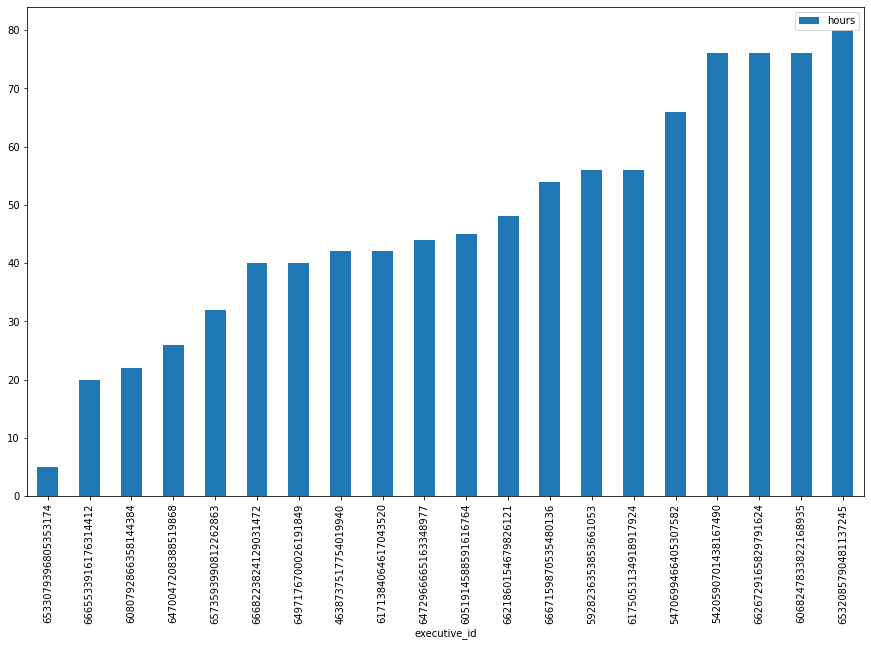

In [15]:
# count = 20
lst_counthours_indate[['executive_id', 'hours']].head(count).set_index('executive_id')\
                                                            .plot(kind='bar', figsize=(15,9))

Можно предположить, что в марте больше всего свободных дизайнеров, однако, от общего числа данных специалистов около 19% попали в выборку.

## 3. Построить распределение длительностей проектов.

In [16]:
stage_dist = df_s_projects.groupby('project_id')['stagedproject_id'].count().sort_values()
stage_dist

project_id
6661025295757684757     1
6655830099008738502     1
6655830103316436170     1
6656201184195900205     1
6658185759708791848     1
                       ..
6636424689428284474     8
6483439960094487942     8
6637436467762047922     8
6509411090462479683    11
5574352484845039347    13
Name: stagedproject_id, Length: 278, dtype: int64

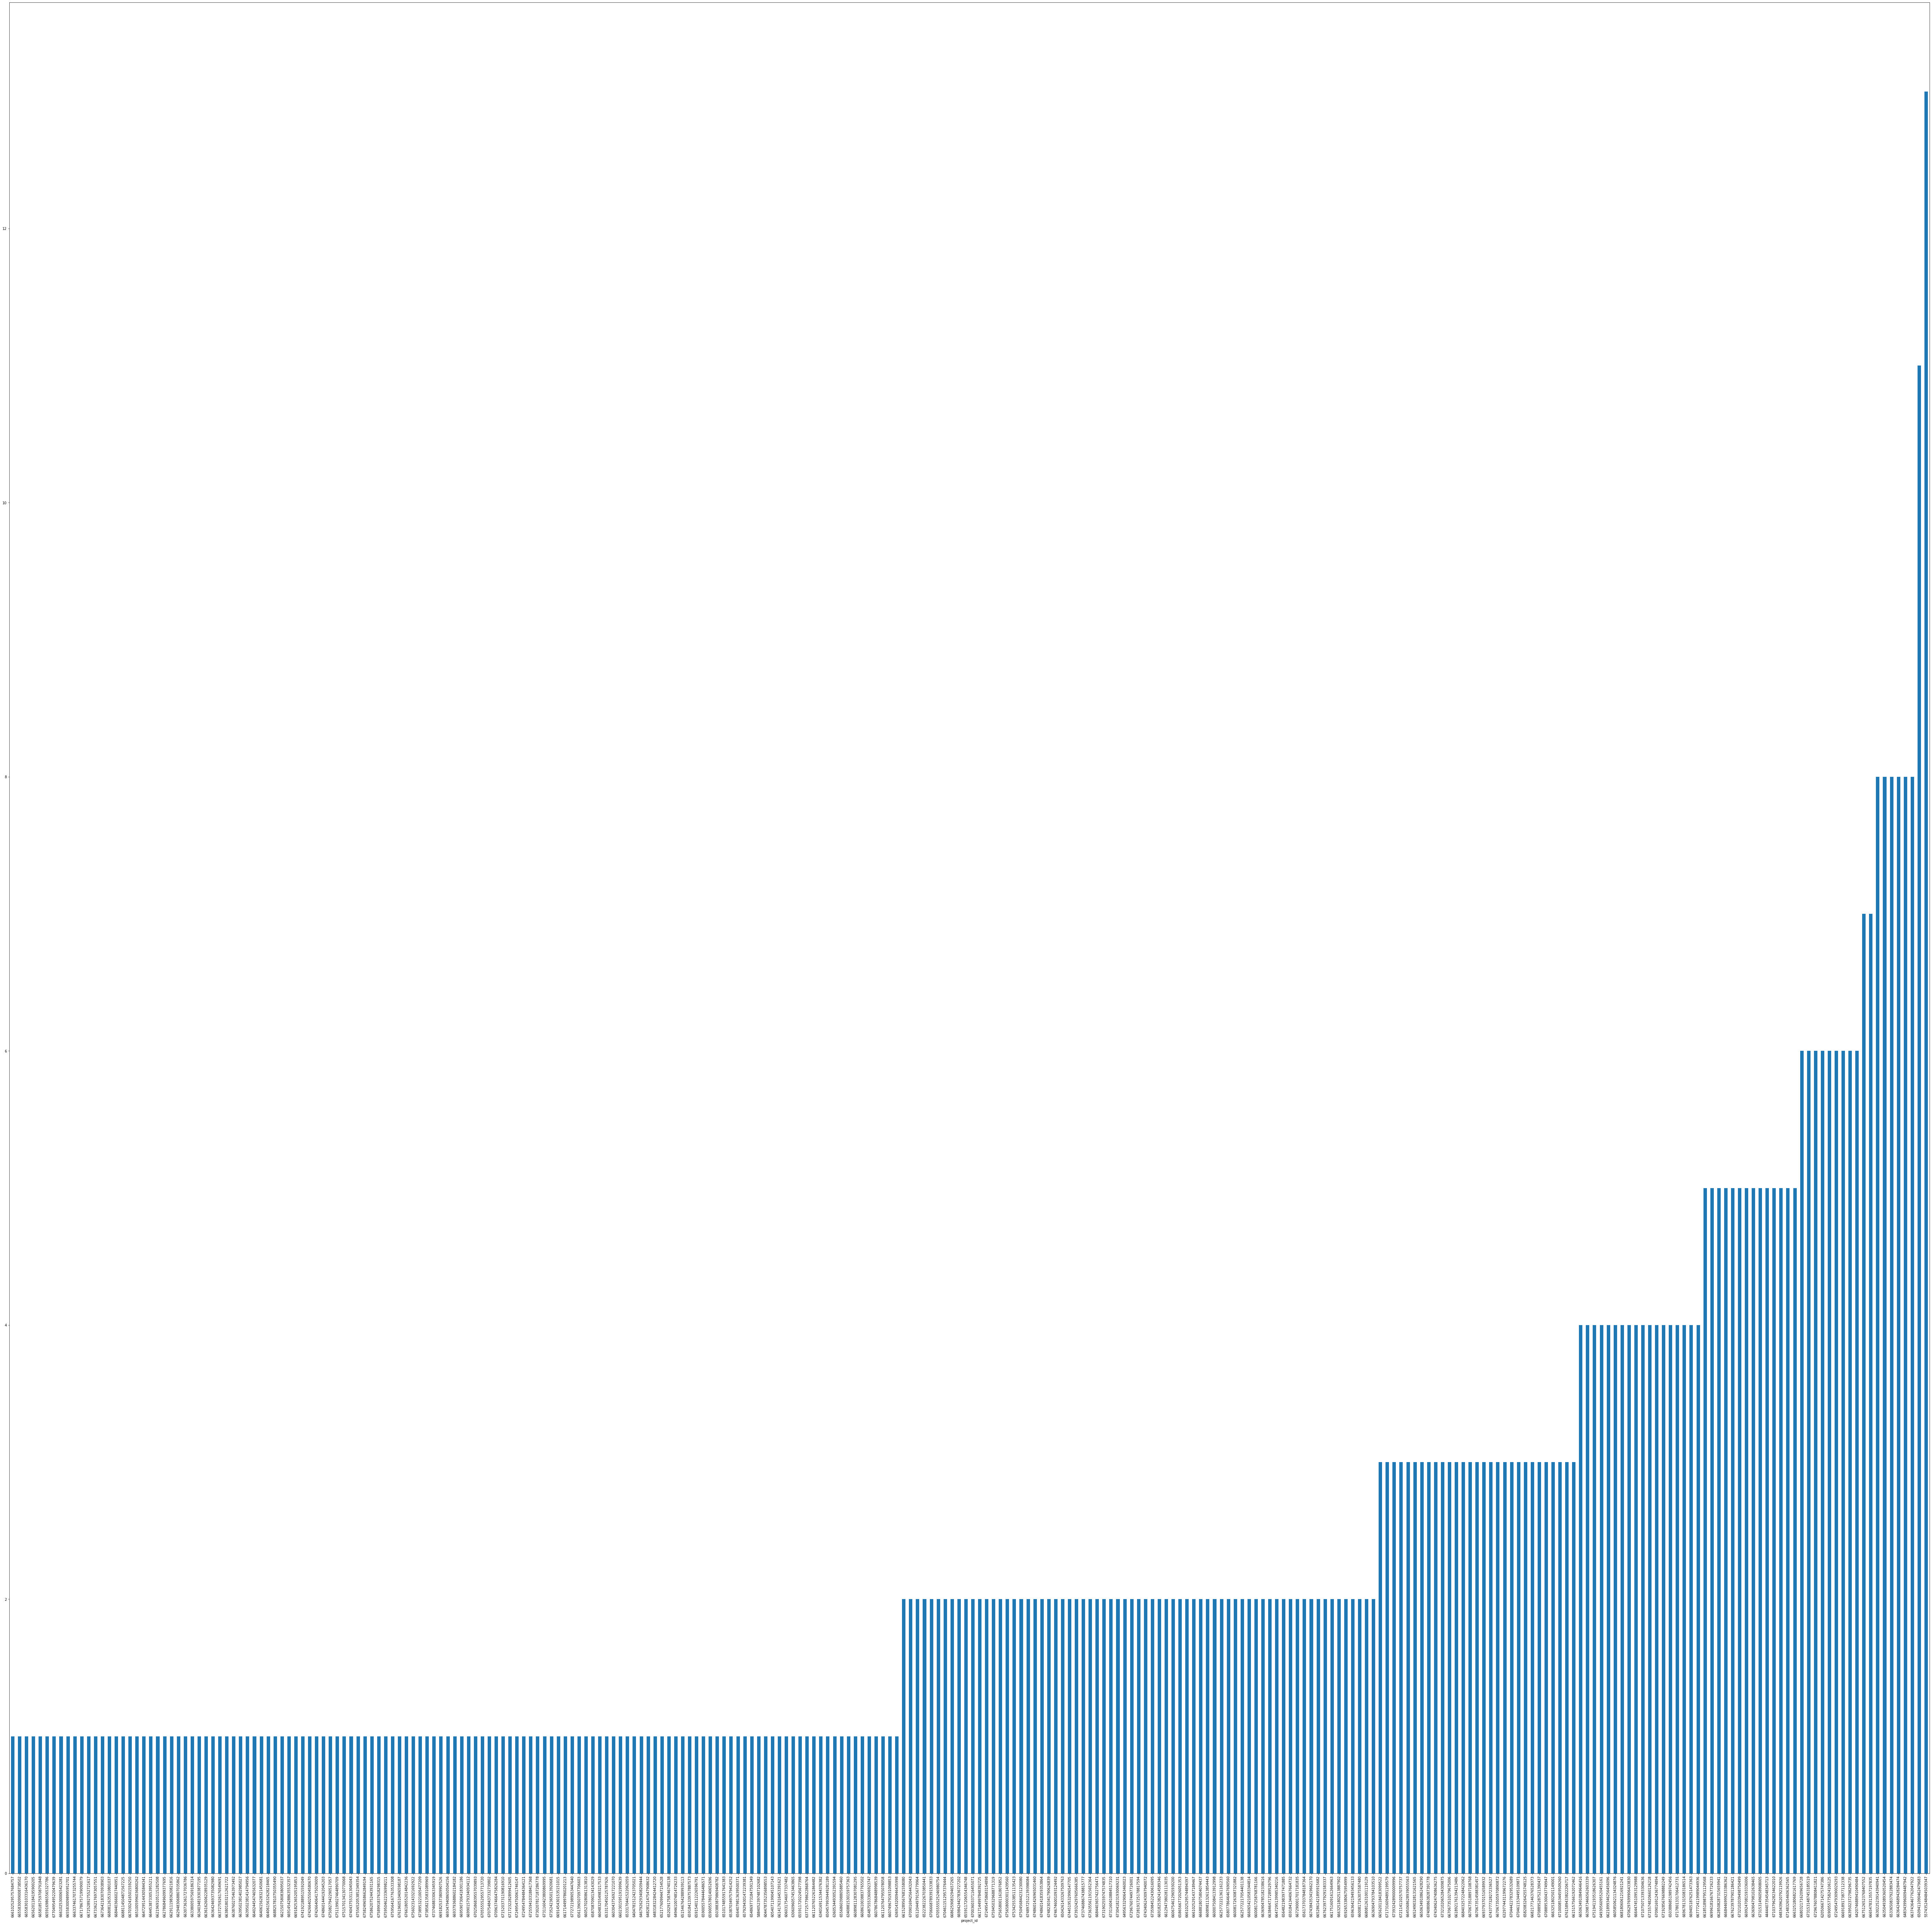

In [17]:
stage_dist.plot(kind='bar', figsize=(100,100))

## 4. Построить график занятости по специалистам от максимально возможного в течение года 

Вывод всех сотрудников, с распределением их специальностей.

In [18]:
df_spec.groupby('spec').agg(count_spec=('spec', 'count'), mean_spec=('spec', lambda x: len(x)/len(df_spec)))

,count_spec,mean_spec
spec,,
архитектор,5,0.041667
бета-тестер,1,0.008333
верстальщик,5,0.041667
визуализатор,2,0.016667
главный архитектор,2,0.016667
дизайнер,59,0.491667
иллюстратор,2,0.016667
исследователь,1,0.008333
кодер,12,0.100000


### Построить график занятости дизайнеров

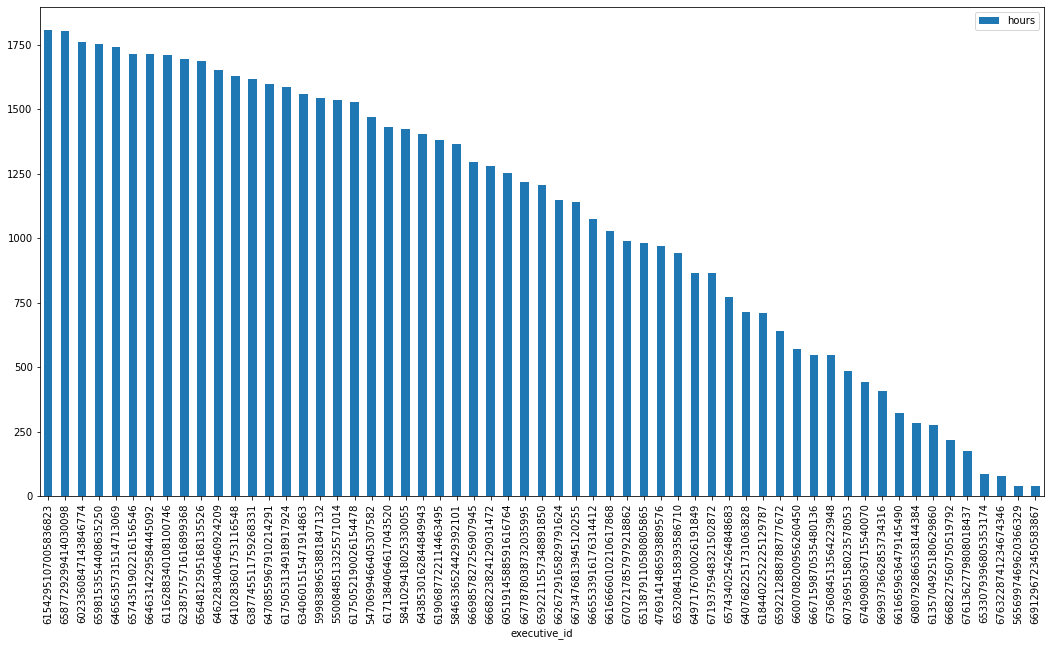

In [19]:
df_h_projects.merge(df_spec, on='executive_id', how='left').query('spec == "дизайнер"').groupby('executive_id').agg({'hours': 'sum'})\
                                                           .sort_values(by='hours', ascending=False).plot(kind='bar', figsize=(18,9))

### Построить график занятости технологов

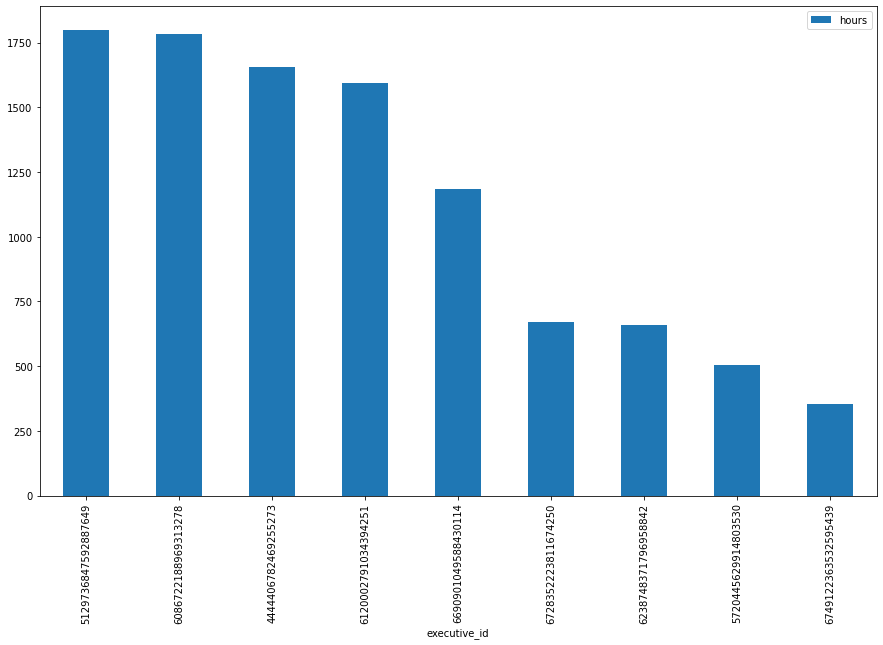

In [20]:
df_h_projects.merge(df_spec, on='executive_id', how='left').query('spec == "технолог"').groupby('executive_id').agg({'hours': 'sum'})\
                                                           .sort_values(by='hours', ascending=False).plot(kind='bar', figsize=(15,9))

### Построить график занятости всех специалистов

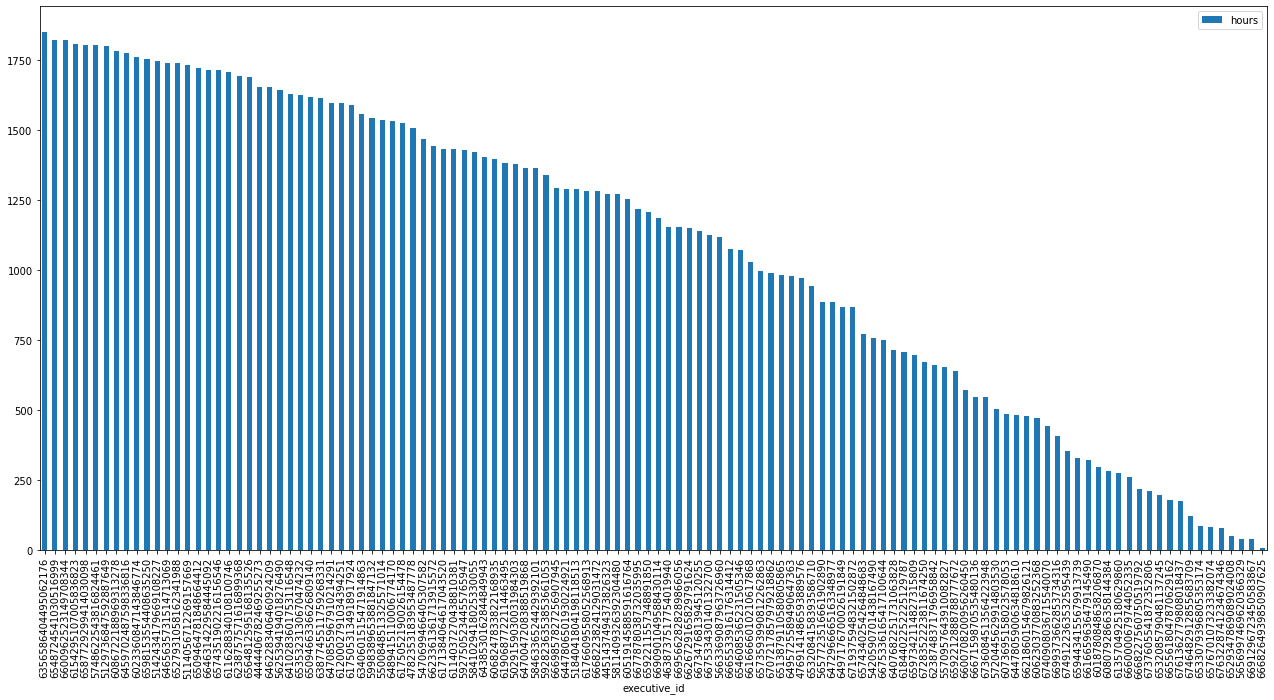

In [21]:
df_h_projects.merge(df_spec, on='executive_id', how='left').groupby('executive_id').agg({'hours': 'sum'}).sort_values(by='hours', ascending=False)\
                                                                                                         .plot(kind='bar', figsize=(22,10))